In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
from matplotlib.patches import Rectangle
from IPython.display import Image, display

### Functions

In [2]:
#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    
    variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','final_age','final_dens','init_dens']
    
    dict_var = {}
    
    idx = np.where(datafile['final_section']==sectionnum)
    
    for var in variables:
        if var == 'final_age':
            agetd = datafile[var].values
            agehr = agetd.astype('float64')/(10**9*3600)
            age = agehr[idx]
            dict_var[var] = age
        else:
            data_sec = datafile[var]
            dict_var[var] = data_sec[idx]
        
    
    return dict_var      

def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                try:
                    rect = Rectangle((u_lons[i]/m2lon, w_depths[j+1]), u_lons[i+1]/m2lon-u_lons[i]/m2lon, w_depths[j+2]-w_depths[j+1])
                    topo.append(rect)
                except:
                    pass

    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)


def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,latgridi,depi,time,title,cblabel,ylabel,vmin=None,vmax=None):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,2))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],2)])
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')
    else:
        axn.set_yticks([])
        
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

In [3]:
def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Longitude (°E)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

In [4]:
def plotCS2(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1 #actually lon
    fmask = mesh.fmask[0,:,:,latgridf] # Giving mask of longitudes
    tmask = mesh.tmask[0]
    
    lons = data.init_lat[(data.final_section != 0)]
    
    f_lons = mesh.gphif[0,:, latgridf]
    u_lons = mesh.gphiv[0,:, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Latitude (°W)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

In [5]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

### Import data

In [6]:
dataVStoPR_haro = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forVStoPR_haro/01jan18_s1t35/ariane_positions_quantitative.nc')
dataVStoPR_haro07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forVStoPR_haro/01jul18_s1t35/ariane_positions_quantitative.nc')
dataVStoPR_ros = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forVStoPR_ros/for_straight_01jan18_s1t35/ariane_positions_quantitative.nc')
dataVStoPR_ros07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forVStoPR_ros/for_straight_01mar18_s1t35/ariane_positions_quantitative.nc')
dataVStoPR_sjc = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forVStoPR_sjc/for_straight_01jan18_s1t35/ariane_positions_quantitative.nc')
datafPR_haro = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forPR_haro/01jan18_s1t35/ariane_positions_quantitative.nc')
datafPR_ros = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forpr_ros/for_straight_01jan18_s1t35/ariane_positions_quantitative.nc')
datafPR_sjc = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forpr_sjc/for_straight_01jan18_s1t35/ariane_positions_quantitative.nc')
databPR_ros = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backpr_ros/for_straight_01jan18_s1t35/ariane_positions_quantitative.nc')

datafPR_ros2 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forpr_ros2/for_straight_01jan18_s1t50/ariane_positions_quantitative.nc') #ros2 has boundary at SJCEast
datafPR_ros3 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forpr_ros3/for_straight_01jan18_s1t50/ariane_positions_quantitative.nc')
datafPR_ros07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forpr_ros/for_straight_01jul18_s1t35/ariane_positions_quantitative.nc')
datafPR_ros307 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forpr_ros3/for_straight_01jul18_s1t50/ariane_positions_quantitative.nc')
datafPR_haro2 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forpr_haro2/for_straight_01jan18_s1t50/ariane_positions_quantitative.nc')
datafPR_haro207 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forpr_haro2/for_straight_01jul18_s1t50/ariane_positions_quantitative.nc')
datafPR_haro307 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forpr_haro2/for_straight_01jul18_s1t50/ariane_positions_quantitative.nc')
datafPR_haro3 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forpr_haro3/for_straight_01jan18_s1t50/ariane_positions_quantitative.nc')
datafPR_sjc2 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forpr_sjc2/for_straight_01jan18_s1t50/ariane_positions_quantitative.nc')
datafPR_sjc207 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forpr_sjc2/for_straight_01jul18_s1t50/ariane_positions_quantitative.nc')
datafPR_sjc3 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forpr_sjc3/for_straight_01jan18_s1t50/ariane_positions_quantitative.nc')
datafPR_sjc307 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forpr_sjc3/for_straight_01jul18_s1t50/ariane_positions_quantitative.nc')

datafvs_haro3 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forvs_haro3/01jan18_s1t50/ariane_positions_quantitative.nc')
datafvs_ros3 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forvs_ros3/01jan18_s1t50/ariane_positions_quantitative.nc')
datafvs_sjc3 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forvs_sjc3/01jan18_s1t50/ariane_positions_quantitative.nc')
datafvs_haro307 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forvs_haro3/01jul18_s1t50/ariane_positions_quantitative.nc')
datafvs_ros307 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forvs_ros3/01jul18_s1t50/ariane_positions_quantitative.nc')
datafvs_sjc307 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forvs_sjc3/01jul18_s1t50/ariane_positions_quantitative.nc')

datafvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s1t21/ariane_positions_quantitative.nc')
datafvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jul18_s1t21/ariane_positions_quantitative.nc')
datafpr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18_PR/for_straight_01jan18_s1t21/ariane_positions_quantitative.nc')
datafpr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18_PR/for_straight_01jul18_s1t21/ariane_positions_quantitative.nc')

In [7]:
data_dict = {'dataVStoPR_haro':dataVStoPR_haro,'dataVStoPR_ros':dataVStoPR_ros,'dataVStoPR_haro07':dataVStoPR_haro07,'dataVStoPR_ros07':dataVStoPR_ros07,'dataVStoPR_sjc':dataVStoPR_sjc,
             'datafPR_ros':datafPR_ros,'datafPR_sjc':datafPR_sjc,'datafPR_haro':datafPR_haro,'databPR_ros':databPR_ros,'datafPR_ros2':datafPR_ros2,'datafPR_ros07':datafPR_ros07,'datafPR_haro2':datafPR_haro2,
             'datafPR_haro207':datafPR_haro207,'datafPR_ros3':datafPR_ros3,'datafPR_ros307':datafPR_ros307,'datafPR_sjc2':datafPR_sjc2,'datafPR_sjc207':datafPR_sjc207,'datafPR_haro3':datafPR_haro3,'datafPR_haro307':datafPR_haro307,
             'datafvs_haro3':datafvs_haro3,'datafvs_ros3':datafvs_ros3,'datafvs_sjc3':datafvs_sjc3,'datafvs_haro307':datafvs_haro307,'datafvs_ros307':datafvs_ros307,'datafvs_sjc307':datafvs_sjc307,'datafvs':datafvs,'datafvs07':datafvs07,
             'datafPR_sjc3':datafPR_sjc3,'datafPR_sjc307':datafPR_sjc307,'datafpr':datafpr,'datafpr07':datafpr07
             }


In [8]:
data_dict

{'dataVStoPR_haro': <xarray.Dataset>
 Dimensions:        (ntraj: 25122)
 Dimensions without coordinates: ntraj
 Data variables: (12/25)
     init_x         (ntraj) float64 ...
     init_y         (ntraj) float64 ...
     init_z         (ntraj) float64 ...
     init_t         (ntraj) float64 ...
     init_age       (ntraj) timedelta64[ns] ...
     init_transp    (ntraj) float64 ...
     ...             ...
     init_lon       (ntraj) float64 ...
     init_lat       (ntraj) float64 ...
     init_depth     (ntraj) float64 ...
     final_lon      (ntraj) float64 ...
     final_lat      (ntraj) float64 ...
     final_depth    (ntraj) float64 ...
 Attributes: (12/108)
     key_roms:                  .FALSE.
     key_mars:                  .FALSE.
     key_symphonie:             .FALSE.
     key_B2C_grid:              .FALSE.
     key_sequential:            .TRUE.
     key_alltracers:            .TRUE.
     ...                        ...
     ind0_sa:                   1
     indn_sa:        

In [9]:
# sectionnum = [0,2,3,4,5,6,7,8,9]
# starttime = 1
# endtime = 24
# time = 23

# dict_sectiontransp = {}

# for var in data_dict.keys():
    
#     if var not in dict_sectiontransp:
#         dict_sectiontransp[var] = []
        
#     for section in sectionnum:
#         dict_sectiontransp[var].append(get_datat(data_dict[var],section,starttime,endtime))


In [10]:
sectionnum = [0,2,3,4,5,6,7,8,9]
starttime = 1
endtime = 24
time = 23

dict_sectiontransp = {}

for var in data_dict.keys():
    
    if var not in dict_sectiontransp:
        dict_sectiontransp[var] = []
        
    for section in sectionnum:
        dict_sectiontransp[var].append(get_datat(data_dict[var],section,starttime,endtime))


    data_sec = get_secdata(data_dict[var],0)
    age_md= data_sec['final_age']
    transp_ref = np.sum(data_sec['final_transp'][age_md >= 24])/23
    print(transp_ref.values)
    total_md = np.sum(data_sec['final_transp'])/23
    dict_sectiontransp[var] = np.array(np.copy(dict_sectiontransp[var]))
    dict_sectiontransp[var][0] = transp_ref.values

84567.62267013804
53600.300854619025
64160.38912094204
62073.20957615666
53782.074661457686
32627.08758993712
29253.52854030209
30851.664300641856
40160.74951639391
37930.54456951054
41439.071861988676
39819.18122104529
43590.638616941505
37930.54456951054
42922.78689623622
35764.13635045573
42675.11431098855
39819.18122104529
43590.638616941505
89682.93682361064
56824.004040343265
57015.342931181796
72607.58474121091
56707.43544097049
53464.12828148143
52974.56078644505
45361.10333621928
35764.13635045573
42675.11431098855
30707.291369342944
41823.64012711754


Text(0.5, 1.0, 'Transport only through Haro (July)')

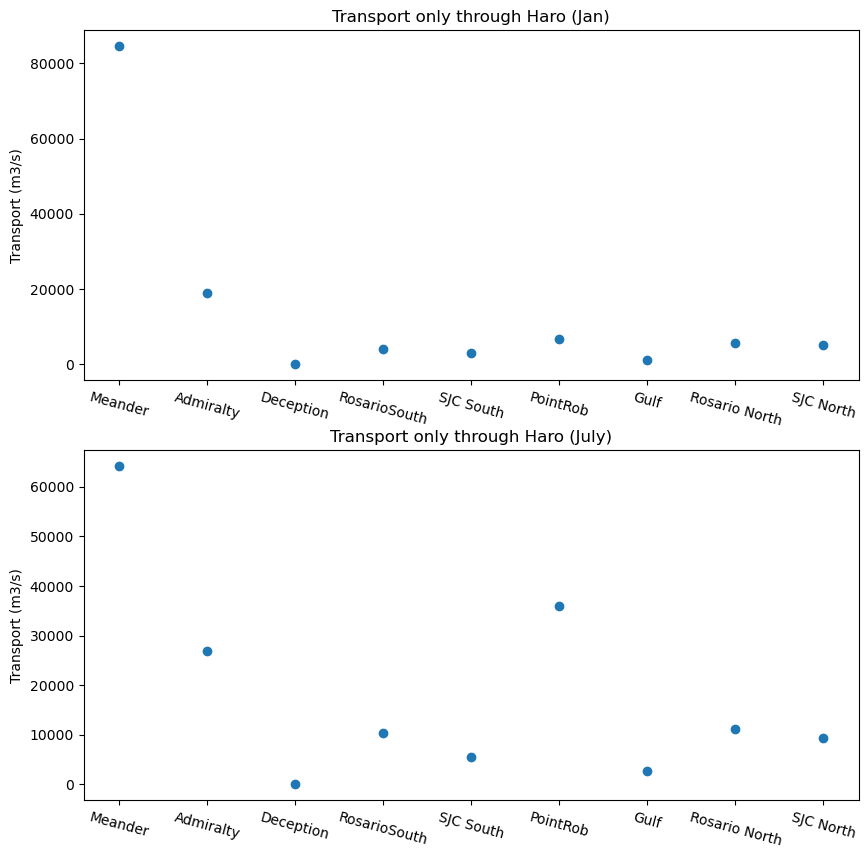

In [11]:
fig,ax = plt.subplots(2,1,figsize=(10,10))

ax[0].scatter(np.arange(0,9,1),dict_sectiontransp['dataVStoPR_haro'])
ax[0].set_xticks(np.arange(0,9,1))
ax[0].set_xticklabels(['Meander','Admiralty','Deception','RosarioSouth','SJC South','PointRob','Gulf','Rosario North','SJC North'],rotation=-15)
ax[0].set_ylabel('Transport (m3/s)')
ax[0].set_title('Transport only through Haro (Jan)')

ax[1].scatter(np.arange(0,9,1),dict_sectiontransp['dataVStoPR_haro07'])
ax[1].set_xticks(np.arange(0,9,1))
ax[1].set_xticklabels(['Meander','Admiralty','Deception','RosarioSouth','SJC South','PointRob','Gulf','Rosario North','SJC North'],rotation=-15)
ax[1].set_ylabel('Transport (m3/s)')
ax[1].set_title('Transport only through Haro (July)')


The problem could be that I ran it at the same time as it was running a year long run in another tmux terminal? Try to run it again later ...

Text(0.5, 1.0, 'Transport only through Rosario')

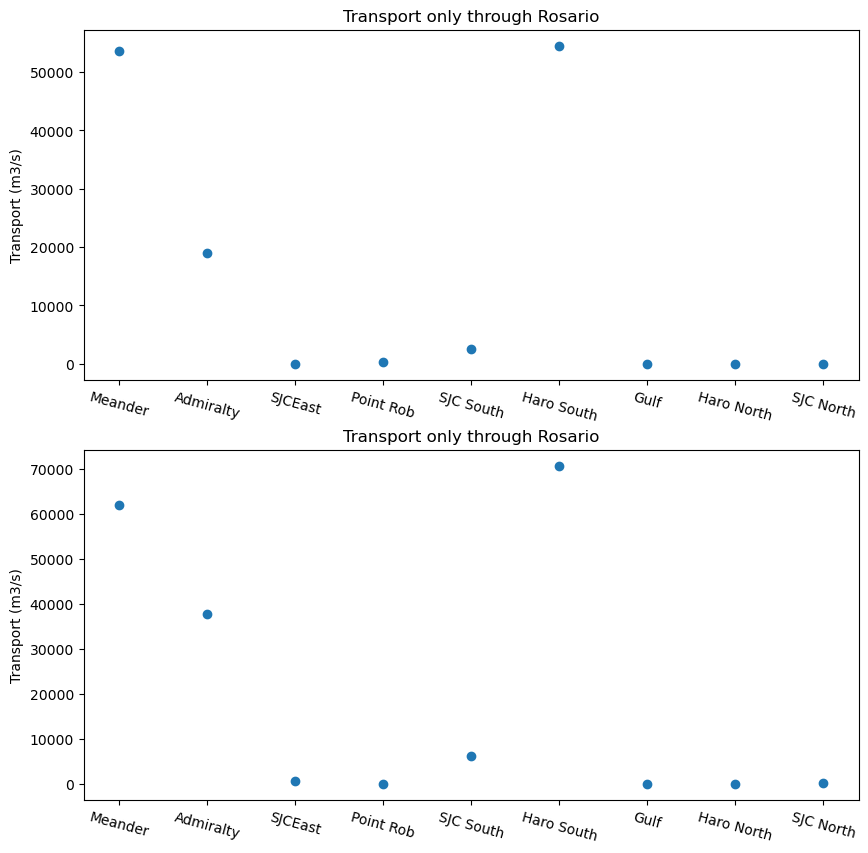

In [12]:
#VicSill through Rosario

fig,ax = plt.subplots(2,1,figsize=(10,10))

ax[0].scatter(np.arange(0,9,1),dict_sectiontransp['dataVStoPR_ros'])
ax[0].set_xticks(np.arange(0,9,1))
ax[0].set_xticklabels(['Meander','Admiralty','SJCEast','Point Rob','SJC South','Haro South','Gulf','Haro North','SJC North'],rotation=-15)
ax[0].set_ylabel('Transport (m3/s)')
ax[0].set_title('Transport only through Rosario')

ax[1].scatter(np.arange(0,9,1),dict_sectiontransp['dataVStoPR_ros07'])
ax[1].set_xticks(np.arange(0,9,1))
ax[1].set_xticklabels(['Meander','Admiralty','SJCEast','Point Rob','SJC South','Haro South','Gulf','Haro North','SJC North'],rotation=-15)
ax[1].set_ylabel('Transport (m3/s)')
ax[1].set_title('Transport only through Rosario')


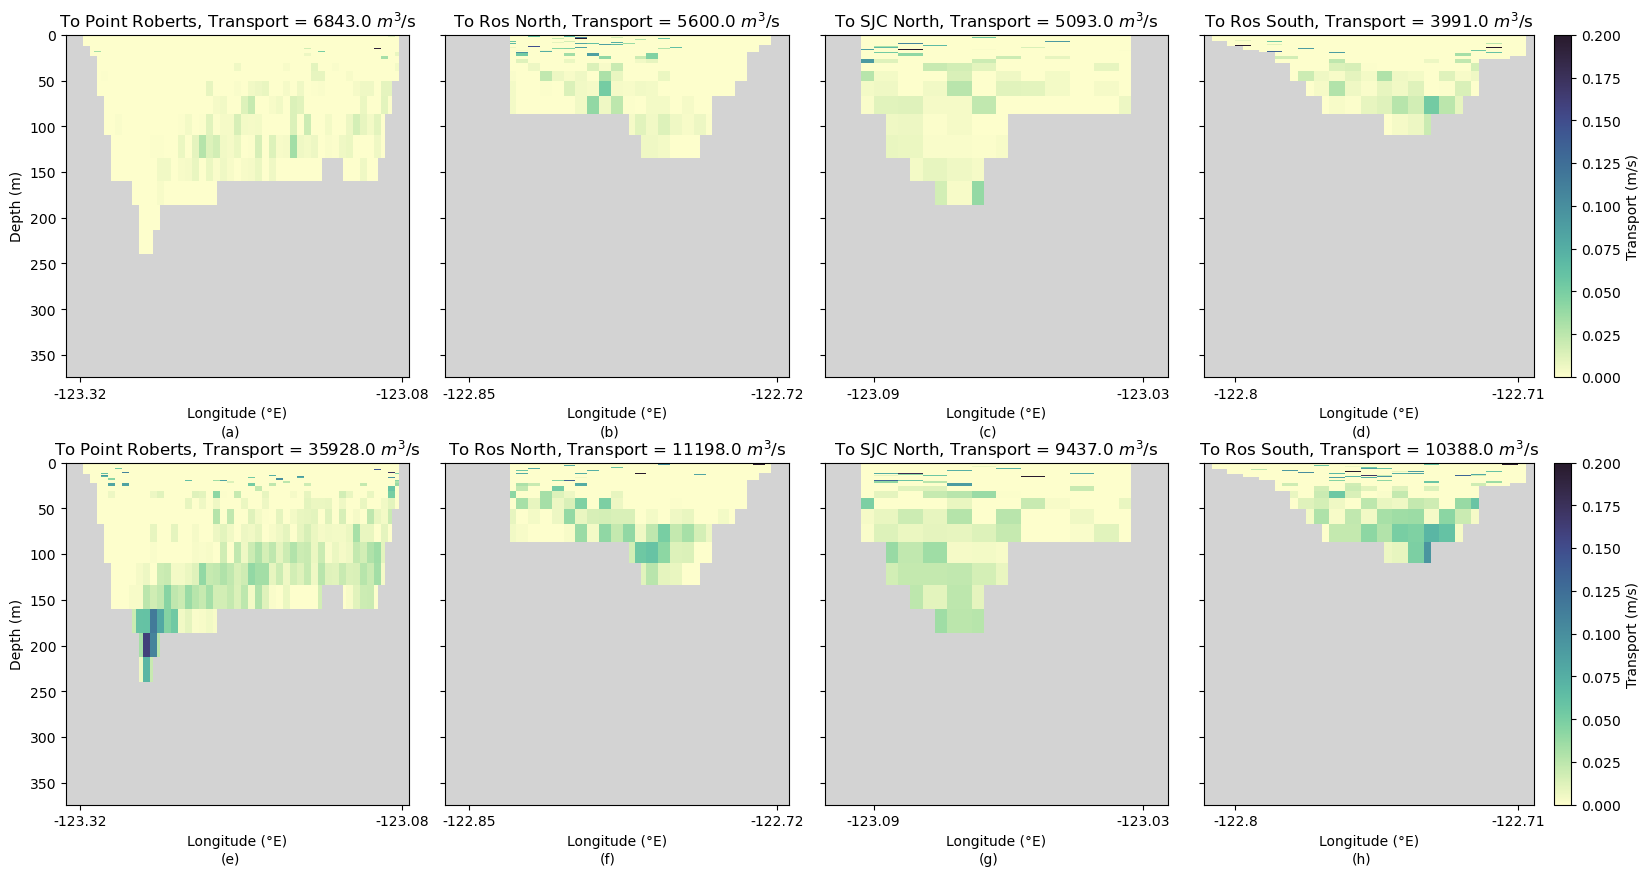

In [13]:
# Section plot of whats going to point rob vs. rosario north

#VicSill through Haro
VStoPR_PR = get_secdata(data_dict['dataVStoPR_haro'],6)
VStoPR_rosN = get_secdata(data_dict['dataVStoPR_haro'],8)
VStoPR_sjcN = get_secdata(data_dict['dataVStoPR_haro'],9)
VStoPR_rosS = get_secdata(data_dict['dataVStoPR_haro'],4)

VStoPR_PR07 = get_secdata(data_dict['dataVStoPR_haro07'],6)
VStoPR_rosN07 = get_secdata(data_dict['dataVStoPR_haro07'],8)
VStoPR_sjcN07 = get_secdata(data_dict['dataVStoPR_haro07'],9)
VStoPR_rosS07 = get_secdata(data_dict['dataVStoPR_haro07'],4)

lonWharo = 215
lonEharo = 245
latharo = 300
lonWros=283
lonEros=305
latros = 267
lonWrosN=305
lonErosN=335
latrosN = 317
latsjcN = 317
lonWsjcN = 260
lonEsjcN = 275
lonWadm = 200
lonEadm = 262
latadm = 218
lonWg1 = 235
lonEg1 = 253
latg1 = 386
lonWpr = 260
lonEpr = 310
latpr = 386
latsjcS = 282
lonWsjcS = 258
lonEsjcS = 268
lonWharoS = 215
lonEharoS = 245
latharoS = 300

title = f"To Point Roberts, Transport = {np.round(dict_sectiontransp['dataVStoPR_haro'][5],0)} $m^3$/s"
title2 = f"To Ros North, Transport = {np.round(dict_sectiontransp['dataVStoPR_haro'][7],0)} $m^3$/s"
title3 = f"To SJC North, Transport = {np.round(dict_sectiontransp['dataVStoPR_haro'][8],0)} $m^3$/s"
title4 = f"To Ros South, Transport = {np.round(dict_sectiontransp['dataVStoPR_haro'][3],0)} $m^3$/s"

fig,[[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]] = plt.subplots(2,4,figsize=(20,10),gridspec_kw={'width_ratios':[1,1,1,1.2]})

plotCS(ax1,VStoPR_PR['final_lon'],VStoPR_PR['final_z'],VStoPR_PR['final_transp'],lonWpr,lonEpr,latpr,38,0.2,time,title,False,True)
plotCS(ax2,VStoPR_rosN['final_lon'],VStoPR_rosN['final_z'],VStoPR_rosN['final_transp'],lonWrosN,lonErosN,latrosN,38,0.2,time,title2,False,False)
plotCS(ax3,VStoPR_sjcN['final_lon'],VStoPR_sjcN['final_z'],VStoPR_sjcN['final_transp'],lonWsjcN,lonEsjcN,latsjcN,38,0.2,time,title3,False,False)
plotCS(ax4,VStoPR_rosS['final_lon'],VStoPR_rosS['final_z'],VStoPR_rosS['final_transp'],lonWros,lonEros,latros,38,0.2,time,title4,True,False)

ax1.text(0.45, -0.17, "(a)", transform=ax1.transAxes)
ax2.text(0.45, -0.17, "(b)", transform=ax2.transAxes)
ax3.text(0.45, -0.17, "(c)", transform=ax3.transAxes)
ax4.text(0.45, -0.17, "(d)", transform=ax4.transAxes)

title = f"To Point Roberts, Transport = {np.round(dict_sectiontransp['dataVStoPR_haro07'][5],0)} $m^3$/s"
title2 = f"To Ros North, Transport = {np.round(dict_sectiontransp['dataVStoPR_haro07'][7],0)} $m^3$/s"
title3 = f"To SJC North, Transport = {np.round(dict_sectiontransp['dataVStoPR_haro07'][8],0)} $m^3$/s"
title4 = f"To Ros South, Transport = {np.round(dict_sectiontransp['dataVStoPR_haro07'][3],0)} $m^3$/s"

plotCS(ax5,VStoPR_PR07['final_lon'],VStoPR_PR07['final_z'],VStoPR_PR07['final_transp'],lonWpr,lonEpr,latpr,38,0.2,time,title,False,True)
plotCS(ax6,VStoPR_rosN07['final_lon'],VStoPR_rosN07['final_z'],VStoPR_rosN07['final_transp'],lonWrosN,lonErosN,latrosN,38,0.2,time,title2,False,False)
plotCS(ax7,VStoPR_sjcN07['final_lon'],VStoPR_sjcN07['final_z'],VStoPR_sjcN07['final_transp'],lonWsjcN,lonEsjcN,latsjcN,38,0.2,time,title3,False,False)
plotCS(ax8,VStoPR_rosS07['final_lon'],VStoPR_rosS07['final_z'],VStoPR_rosS07['final_transp'],lonWros,lonEros,latros,38,0.2,time,title4,True,False)

ax5.text(0.45, -0.17, "(e)", transform=ax5.transAxes)
ax6.text(0.45, -0.17, "(f)", transform=ax6.transAxes)
ax7.text(0.45, -0.17, "(g)", transform=ax7.transAxes)
ax8.text(0.45, -0.17, "(h)", transform=ax8.transAxes)

fig.subplots_adjust(wspace=0.1, hspace=0.25)


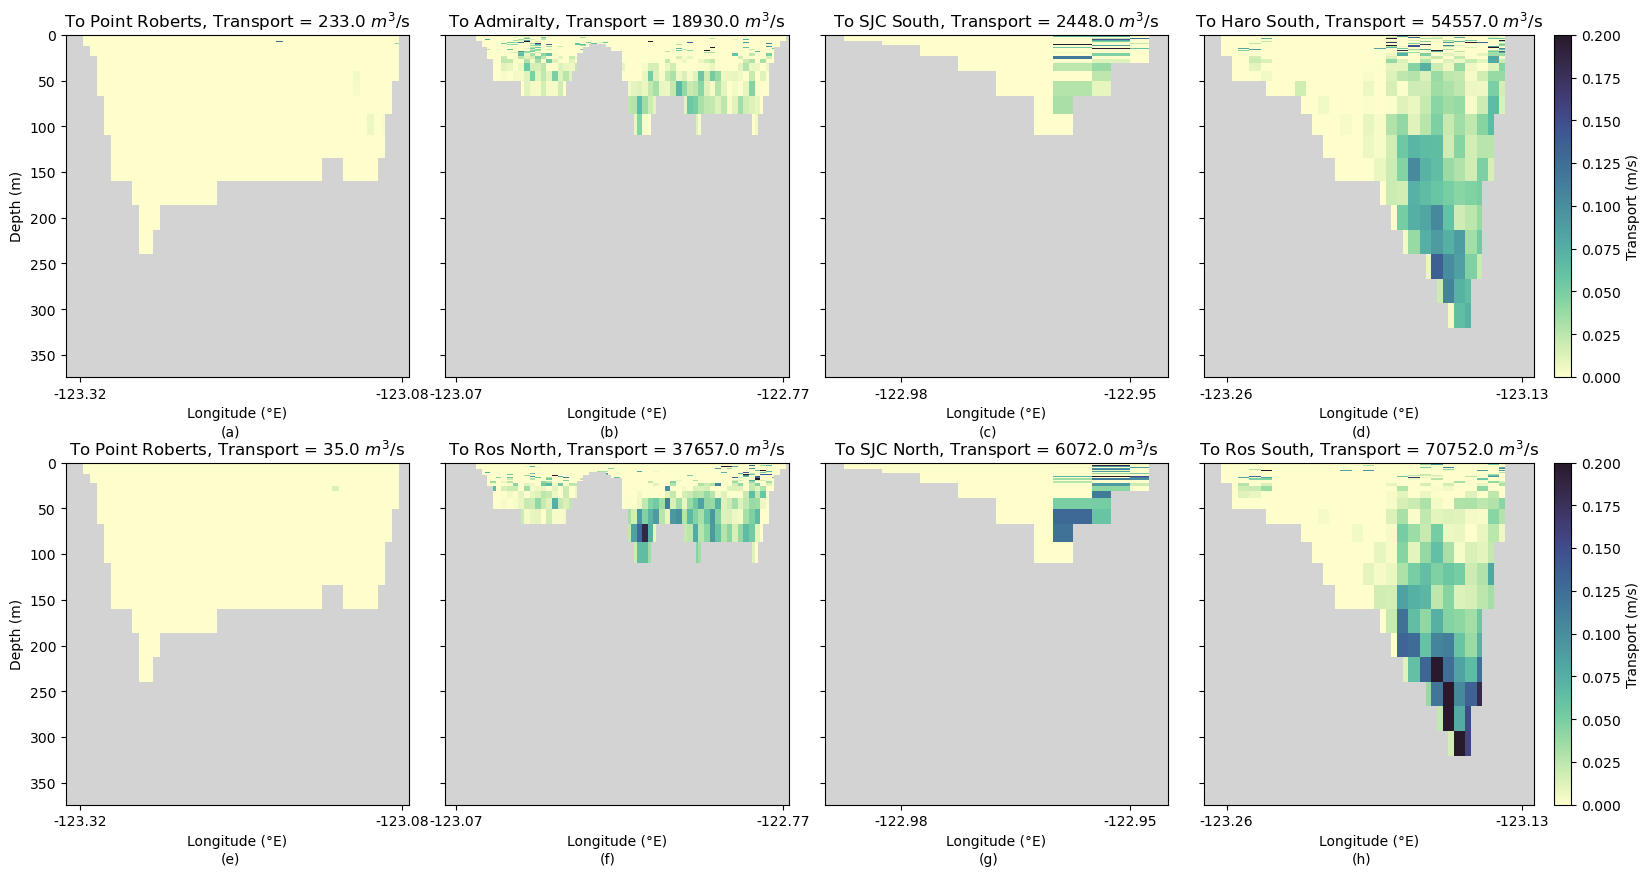

In [14]:
# Section plot of whats going to point rob vs. rosario north

#VicSill through Haro
VStoPRr_PR = get_secdata(data_dict['dataVStoPR_ros'],4)
VStoPRr_adm = get_secdata(data_dict['dataVStoPR_ros'],2)
VStoPRr_sjcS = get_secdata(data_dict['dataVStoPR_ros'],5)
VStoPRr_haroS = get_secdata(data_dict['dataVStoPR_ros'],6)

VStoPRr_PR07 = get_secdata(data_dict['dataVStoPR_ros07'],4)
VStoPRr_adm07 = get_secdata(data_dict['dataVStoPR_ros07'],2)
VStoPRr_sjcS07 = get_secdata(data_dict['dataVStoPR_ros07'],5)
VStoPRr_haroS07 = get_secdata(data_dict['dataVStoPR_ros07'],6)

title = f"To Point Roberts, Transport = {np.round(dict_sectiontransp['dataVStoPR_ros'][3],0)} $m^3$/s"
title2 = f"To Admiralty, Transport = {np.round(dict_sectiontransp['dataVStoPR_ros'][1],0)} $m^3$/s"
title3 = f"To SJC South, Transport = {np.round(dict_sectiontransp['dataVStoPR_ros'][4],0)} $m^3$/s"
title4 = f"To Haro South, Transport = {np.round(dict_sectiontransp['dataVStoPR_ros'][5],0)} $m^3$/s"

fig,[[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]] = plt.subplots(2,4,figsize=(20,10),gridspec_kw={'width_ratios':[1,1,1,1.2]})

plotCS(ax1,VStoPRr_PR['final_lon'],VStoPRr_PR['final_z'],VStoPRr_PR['final_transp'],lonWpr,lonEpr,latpr,38,0.2,time,title,False,True)
plotCS(ax2,VStoPRr_adm['final_lon'],VStoPRr_adm['final_z'],VStoPRr_adm['final_transp'],lonWadm,lonEadm,latadm,38,0.2,time,title2,False,False)
plotCS(ax3,VStoPRr_sjcS['final_lon'],VStoPRr_sjcS['final_z'],VStoPRr_sjcS['final_transp'],lonWsjcS,lonEsjcS,latsjcS,38,0.2,time,title3,False,False)
plotCS(ax4,VStoPRr_haroS['final_lon'],VStoPRr_haroS['final_z'],VStoPRr_haroS['final_transp'],lonWharoS,lonEharoS,latharoS,38,0.2,time,title4,True,False)

ax1.text(0.45, -0.17, "(a)", transform=ax1.transAxes)
ax2.text(0.45, -0.17, "(b)", transform=ax2.transAxes)
ax3.text(0.45, -0.17, "(c)", transform=ax3.transAxes)
ax4.text(0.45, -0.17, "(d)", transform=ax4.transAxes)

title = f"To Point Roberts, Transport = {np.round(dict_sectiontransp['dataVStoPR_ros07'][3],0)} $m^3$/s"
title2 = f"To Ros North, Transport = {np.round(dict_sectiontransp['dataVStoPR_ros07'][1],0)} $m^3$/s"
title3 = f"To SJC North, Transport = {np.round(dict_sectiontransp['dataVStoPR_ros07'][4],0)} $m^3$/s"
title4 = f"To Ros South, Transport = {np.round(dict_sectiontransp['dataVStoPR_ros07'][5],0)} $m^3$/s"

plotCS(ax5,VStoPRr_PR07['final_lon'],VStoPRr_PR07['final_z'],VStoPRr_PR07['final_transp'],lonWpr,lonEpr,latpr,38,0.2,time,title,False,True)
plotCS(ax6,VStoPRr_adm07['final_lon'],VStoPRr_adm07['final_z'],VStoPRr_adm07['final_transp'],lonWadm,lonEadm,latadm,38,0.2,time,title2,False,False)
plotCS(ax7,VStoPRr_sjcS07['final_lon'],VStoPRr_sjcS07['final_z'],VStoPRr_sjcS07['final_transp'],lonWsjcS,lonEsjcS,latsjcS,38,0.2,time,title3,False,False)
plotCS(ax8,VStoPRr_haroS07['final_lon'],VStoPRr_haroS07['final_z'],VStoPRr_haroS07['final_transp'],lonWharoS,lonEharoS,latharoS,38,0.2,time,title4,True,False)

ax5.text(0.45, -0.17, "(e)", transform=ax5.transAxes)
ax6.text(0.45, -0.17, "(f)", transform=ax6.transAxes)
ax7.text(0.45, -0.17, "(g)", transform=ax7.transAxes)
ax8.text(0.45, -0.17, "(h)", transform=ax8.transAxes)

fig.subplots_adjust(wspace=0.1, hspace=0.25)


### Through SJC

Text(0.5, 1.0, 'Transport through San Juan Channel')

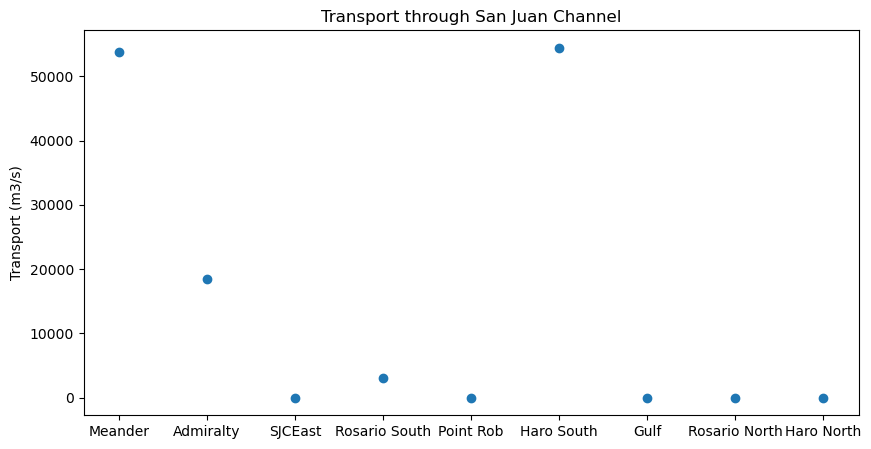

In [15]:
sectionnumplot = np.arange(0,9,1)

fig,ax = plt.subplots(figsize=(10,5))

ax.scatter(sectionnumplot,dict_sectiontransp['dataVStoPR_sjc'])
ax.set_xticks(sectionnumplot)
ax.set_xticklabels(['Meander','Admiralty','SJCEast','Rosario South','Point Rob','Haro South','Gulf','Rosario North','Haro North']);
ax.set_ylabel('Transport (m3/s)')
ax.set_title('Transport through San Juan Channel')


### PR to VS though Haro

Text(0.5, 1.0, 'PR to VS through Haro')

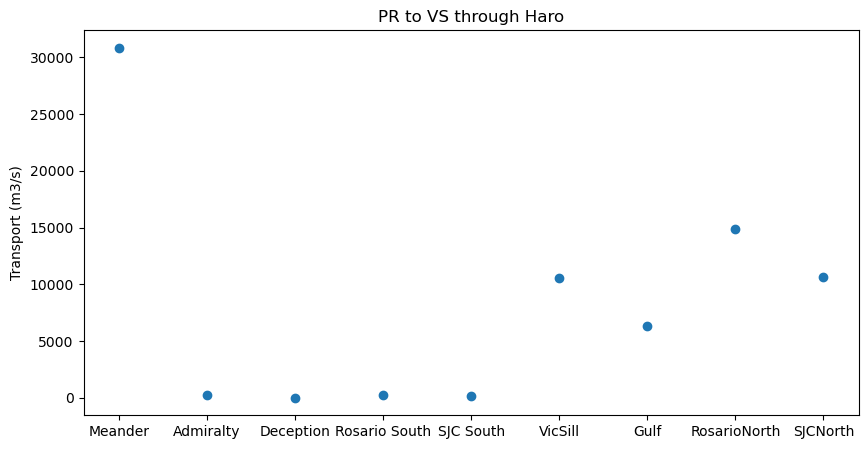

In [16]:
fig,ax = plt.subplots(figsize=(10,5))

ax.scatter(sectionnumplot,dict_sectiontransp['datafPR_haro'])
ax.set_xticks(sectionnumplot)
ax.set_xticklabels(['Meander','Admiralty','Deception','Rosario South','SJC South','VicSill','Gulf','RosarioNorth','SJCNorth'])
ax.set_ylabel('Transport (m3/s)')
ax.set_title('PR to VS through Haro')

Most goes to Rosario and then SJC

### PR to VS through Rosario

#### January 2018

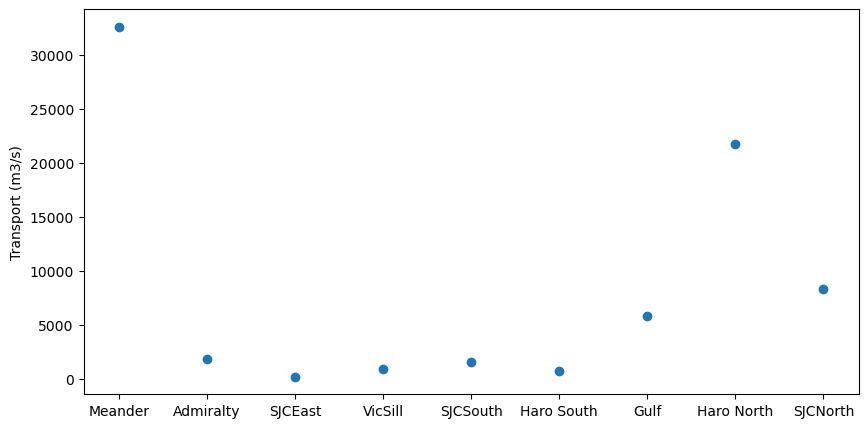

In [17]:
fig,ax = plt.subplots(figsize=(10,5))

ax.scatter(sectionnumplot,dict_sectiontransp['datafPR_ros'])
ax.set_xticks(sectionnumplot)
ax.set_ylabel('Transport (m3/s)')
ax.set_xticklabels(['Meander','Admiralty','SJCEast','VicSill','SJCSouth','Haro South','Gulf','Haro North','SJCNorth']);

Most goes to Haro North with very little making it to VicSill (more going to admiralty even)

Look at summer to see if this changes (would expect that more will go to VicSill in summer?)

#### July 2018

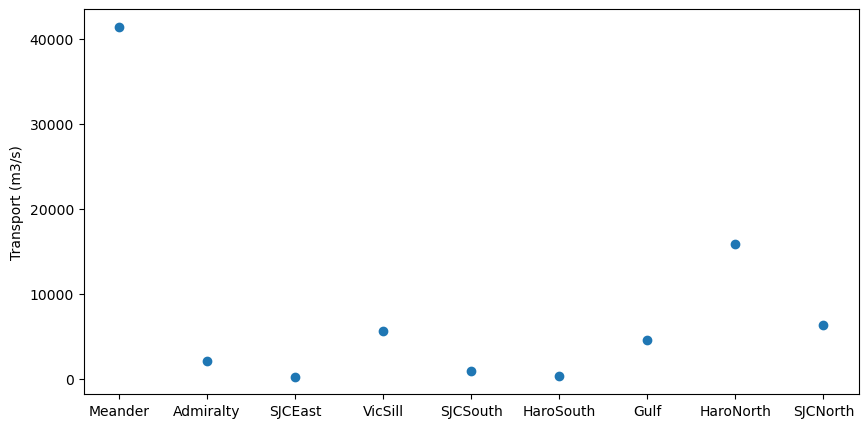

In [18]:
fig,ax = plt.subplots(figsize=(10,5))

ax.scatter(sectionnumplot,dict_sectiontransp['datafPR_ros07'])
ax.set_xticks(sectionnumplot)
ax.set_xticklabels(['Meander','Admiralty','SJCEast','VicSill','SJCSouth','HaroSouth','Gulf','HaroNorth','SJCNorth'])
ax.set_ylabel('Transport (m3/s)');

### PR through Rosario - backwards

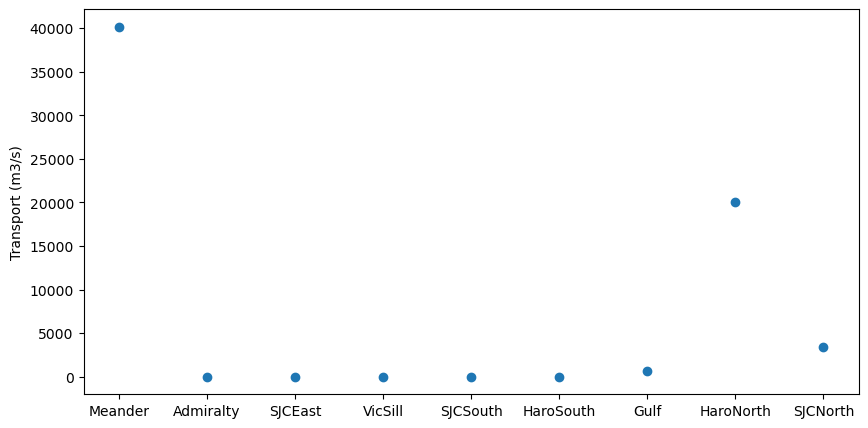

In [19]:
fig,ax = plt.subplots(figsize=(10,5))

ax.scatter(sectionnumplot,dict_sectiontransp['databPR_ros'])
ax.set_ylabel('Transport (m3/s)')
ax.set_xticks(sectionnumplot)
ax.set_xticklabels(['Meander','Admiralty','SJCEast','VicSill','SJCSouth','HaroSouth','Gulf','HaroNorth','SJCNorth']);

Mostly from Haro North ... that  checks out

### PR to VS through SJC

Text(0, 0.5, 'Transport (m3/s)')

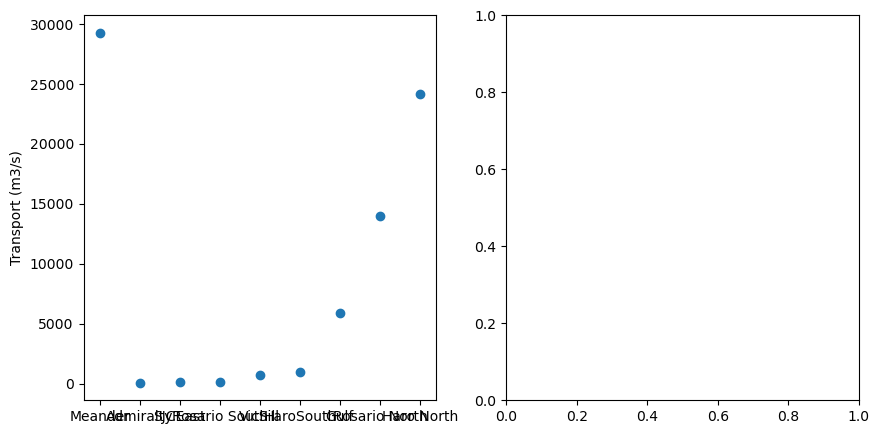

In [20]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].scatter(sectionnumplot,dict_sectiontransp['datafPR_sjc'])
ax[0].set_xticks(sectionnumplot)
ax[0].set_xticklabels(['Meander','Admiralty','SJCEast','Rosario South','VicSill','HaroSouth','Gulf','Rosario North','Haro North']);
ax[0].set_ylabel('Transport (m3/s)')

## Block south boundary

### Through Rosario

Text(0.5, 1.0, 'Transport through Rosario (boundary at SJCEast)')

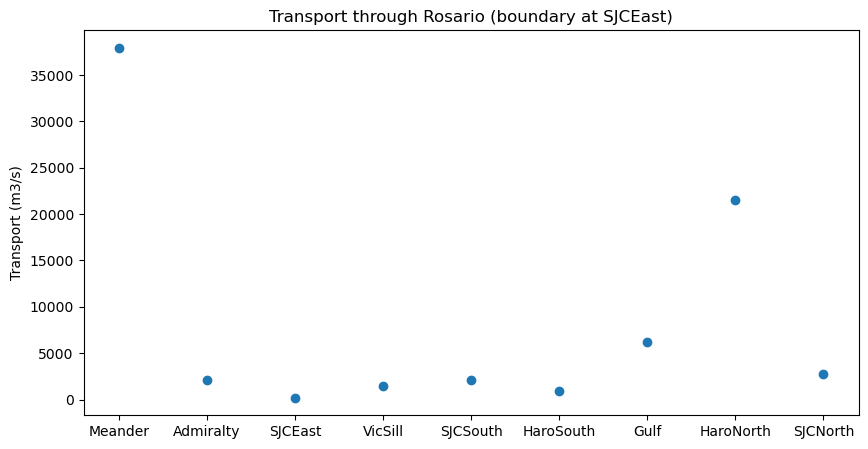

In [21]:
fig,ax = plt.subplots(1,1,figsize=(10,5))

ax.scatter(sectionnumplot,dict_sectiontransp['datafPR_ros2'],label='January')
ax.set_ylabel('Transport (m3/s)')
ax.set_xticks(sectionnumplot)
ax.set_xticklabels(['Meander','Admiralty','SJCEast','VicSill','SJCSouth','HaroSouth','Gulf','HaroNorth','SJCNorth']);
ax.set_title('Transport through Rosario (boundary at SJCEast)')

489.0804545468571 141.10990007898235


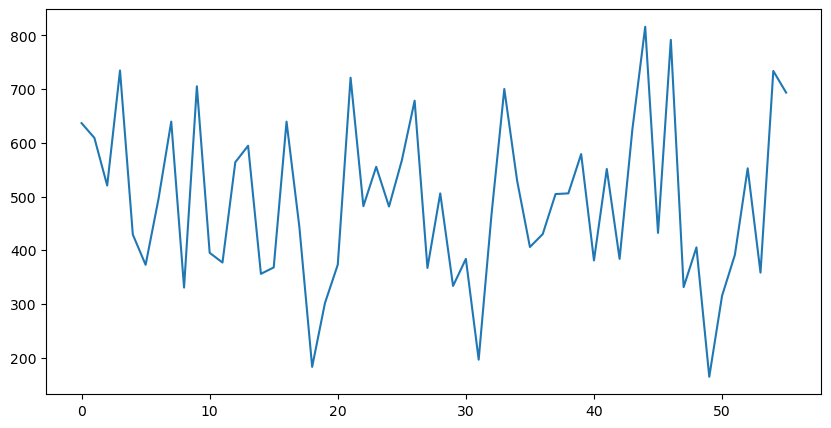

In [22]:
VStoHaroS_ros2 = get_secdata(data_dict['datafPR_ros'],6)
VStoHaroN_ros2 = get_secdata(data_dict['datafPR_ros'],8)

fig,ax = plt.subplots(figsize=(10,5))
# plotTS(ax,'sal',VStoHaroS_ros2['final_lon'],VStoHaroS_ros2['final_z'],VStoHaroS_ros2['final_age'],lonWharoS,lonEharoS,latharoS,38,23,'',True,True)

plt.plot(VStoHaroS_ros2['final_age'])
print(np.mean(VStoHaroS_ros2['final_age']),np.mean(VStoHaroN_ros2['final_age']))

Look at age in SJC

609.9524353433526

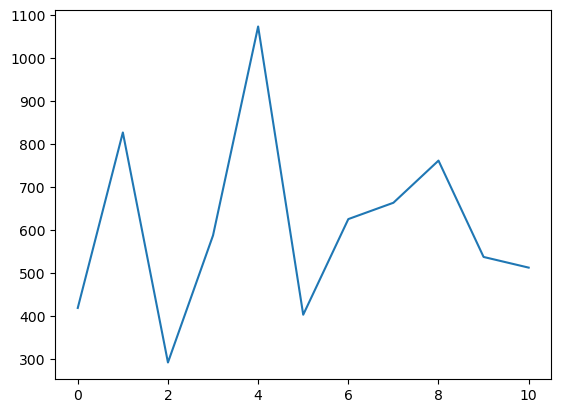

In [23]:
VStoSJCE_ros2 = get_secdata(data_dict['datafPR_ros2'],3)

plt.plot(VStoSJCE_ros2['final_age'])

np.mean(VStoSJCE_ros2['final_age'])

Plots to make:
- distribution with map for south blocks
- figure out how to show comparison of VicSill through each channel
- Cross sections to show whats going on through each reaching VicSill

### Through Rosario (no bndy at SJCEast)

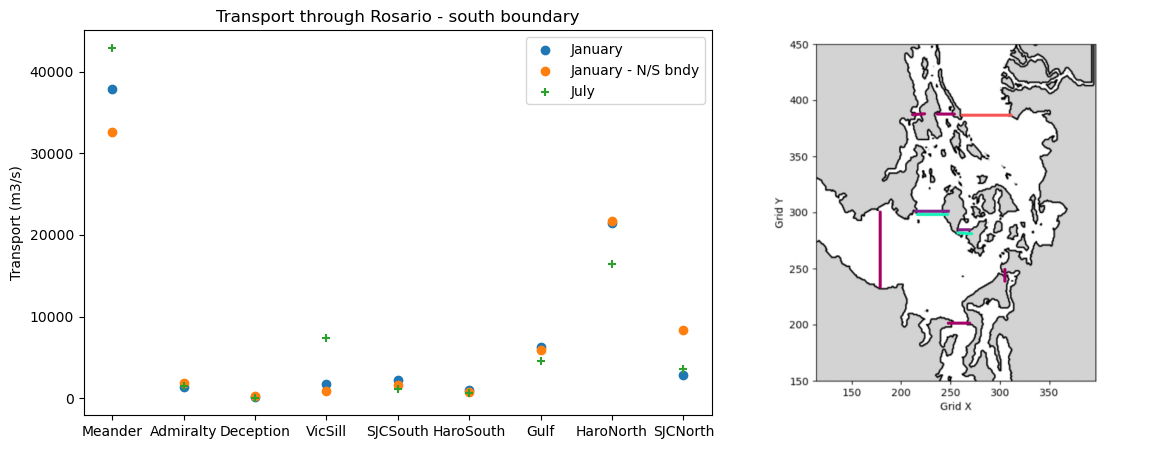

In [24]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].scatter(sectionnumplot,dict_sectiontransp['datafPR_ros3'],label='January')
ax[0].scatter(sectionnumplot,dict_sectiontransp['datafPR_ros'],label='January - N/S bndy')
ax[0].scatter(sectionnumplot,dict_sectiontransp['datafPR_ros307'],marker='+',label='July')
ax[0].set_ylabel('Transport (m3/s)')
ax[0].set_xticks(sectionnumplot)
ax[0].set_xticklabels(['Meander','Admiralty','Deception','VicSill','SJCSouth','HaroSouth','Gulf','HaroNorth','SJCNorth'])
ax[0].set_title('Transport through Rosario - south boundary')
ax[0].legend()

ax[1].imshow(plt.imread('/ocean/cstang/MOAD/analysis-camryn/Figures/map_throughros_Sbndy.jpeg'))
ax[1].axis('off')
fig.subplots_adjust(wspace=-0.15)


In [25]:
dict_sectiontransp['datafPR_ros']

array([32627.08758994,  1852.99420627,   215.80470008,   892.51674968,
        1586.9882648 ,   757.14437329,  5850.69927015, 21732.39067533,
        8346.25866263])

### Through Haro

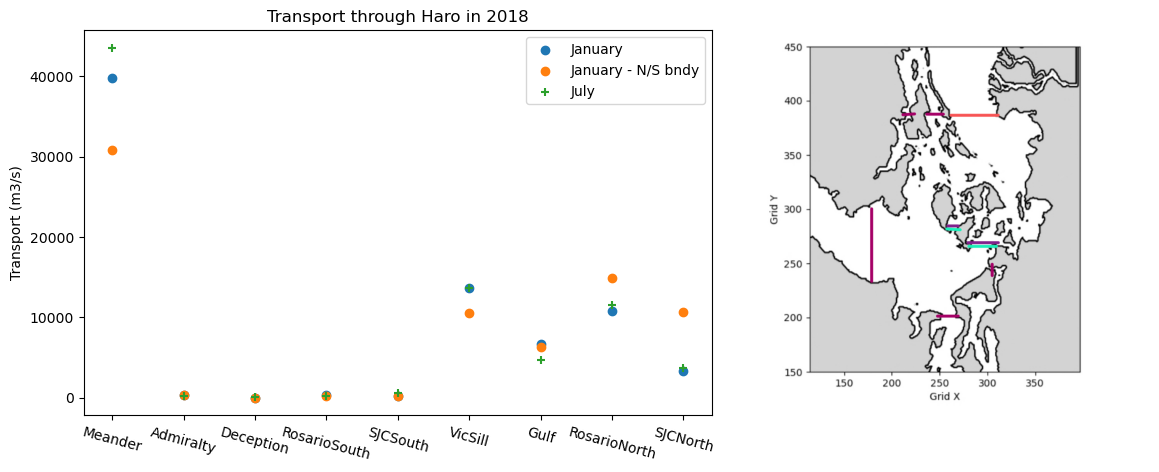

In [26]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].scatter(sectionnumplot,dict_sectiontransp['datafPR_haro2'],label='January')
ax[0].scatter(sectionnumplot,dict_sectiontransp['datafPR_haro'],label='January - N/S bndy')
ax[0].scatter(sectionnumplot,dict_sectiontransp['datafPR_haro207'],marker='+',label='July')
ax[0].set_xticks(sectionnumplot)
ax[0].set_xticklabels(['Meander','Admiralty','Deception','RosarioSouth','SJCSouth','VicSill','Gulf','RosarioNorth','SJCNorth'],rotation=-15)
ax[0].set_ylabel('Transport (m3/s)')
ax[0].set_title('Transport through Haro in 2018')
ax[0].legend()

ax[1].imshow(plt.imread('/ocean/cstang/MOAD/analysis-camryn/Figures/map_throughharo_Sbndy.jpeg'))
ax[1].axis('off')
fig.subplots_adjust(wspace=-0.15)

### Through SJC - south boundary

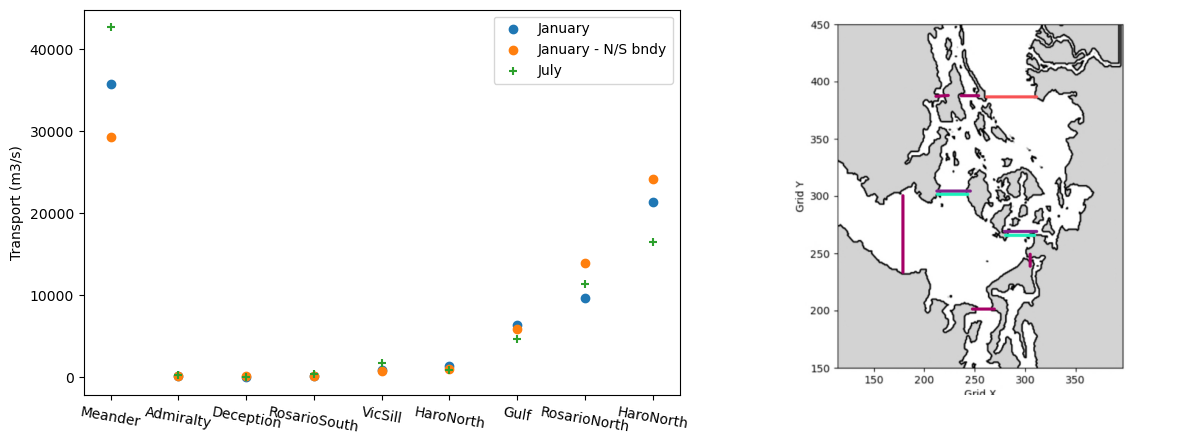

In [27]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].scatter(sectionnumplot,dict_sectiontransp['datafPR_sjc2'],label='January')
ax[0].scatter(sectionnumplot,dict_sectiontransp['datafPR_sjc'],label='January - N/S bndy')
ax[0].scatter(sectionnumplot,dict_sectiontransp['datafPR_sjc207'],marker='+',label='July')
ax[0].set_xticks(sectionnumplot)
ax[0].set_xticklabels(['Meander','Admiralty','Deception','RosarioSouth','VicSill','HaroNorth','Gulf','RosarioNorth','HaroNorth'],rotation=-10)
ax[0].legend()
ax[0].set_ylabel('Transport (m3/s)')

ax[1].imshow(plt.imread('/ocean/cstang/MOAD/analysis-camryn/Figures/map_throughsjc_Sbndy.jpeg'))
ax[1].axis('off')

plt.subplots_adjust(wspace=-0.05)

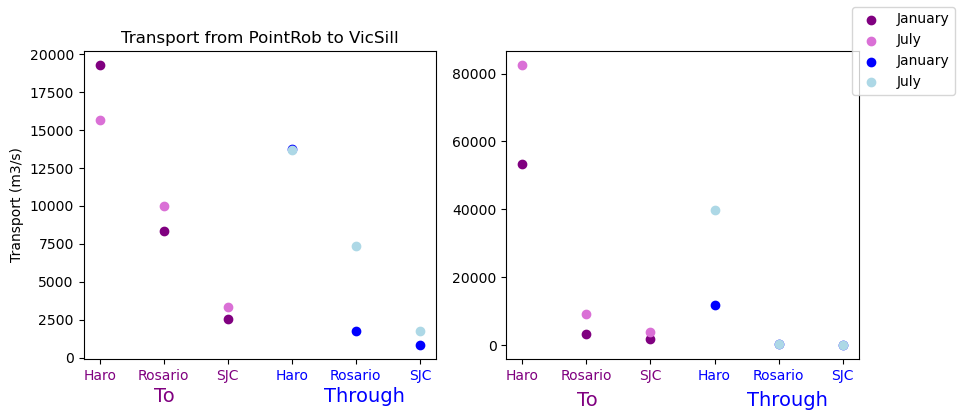

In [33]:
fig,[ax,ax2] = plt.subplots(1,2,figsize=(10,4))

ax.scatter([0,1,2],[dict_sectiontransp['datafpr'][5],dict_sectiontransp['datafpr'][3],dict_sectiontransp['datafpr'][4]],label='January',color='purple')
ax.scatter([0,1,2],[dict_sectiontransp['datafpr07'][5],dict_sectiontransp['datafpr07'][3],dict_sectiontransp['datafpr07'][4]],label='July',color='orchid')
ax.scatter([3,4,5],[dict_sectiontransp['datafPR_haro3'][5],dict_sectiontransp['datafPR_ros3'][3],dict_sectiontransp['datafPR_sjc3'][4]],label='January',color='blue')
ax.scatter([3,4,5],[dict_sectiontransp['datafPR_haro307'][5],dict_sectiontransp['datafPR_ros307'][3],dict_sectiontransp['datafPR_sjc307'][4]],label='July',color='lightblue')

ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(['Haro','Rosario','SJC','Haro','Rosario','SJC'],color='purple')

red_xticks = [3, 4,5]
for i in red_xticks:
    ax.get_xticklabels()[i].set_color('blue')
    
ax.set_ylabel('Transport (m3/s)')
ax.set_title('Transport from PointRob to VicSill')
# ax.set_xlabel('Through') 
ax.text(0.85,-2900,'To',fontsize=14,color='purple')
ax.text(3.5,-2900,'Through',fontsize=14,color='blue')

ax2.scatter([0,1,2],[dict_sectiontransp['datafvs'][5],dict_sectiontransp['datafvs'][3],dict_sectiontransp['datafvs'][4]],color='purple')
ax2.scatter([0,1,2],[dict_sectiontransp['datafvs07'][5],dict_sectiontransp['datafvs07'][3],dict_sectiontransp['datafvs07'][4]],color='orchid')
ax2.scatter([3,4,5],[dict_sectiontransp['datafvs_haro3'][5],dict_sectiontransp['datafvs_ros3'][3],dict_sectiontransp['datafvs_sjc3'][4]],color='blue')
ax2.scatter([3,4,5],[dict_sectiontransp['datafvs_haro307'][5],dict_sectiontransp['datafvs_ros307'][3],dict_sectiontransp['datafvs_sjc307'][4]],color='lightblue')

ax2.set_xticks([0,1,2,3,4,5])
ax2.set_xticklabels(['Haro','Rosario','SJC','Haro','Rosario','SJC'],color='purple')

red_xticks = [3, 4,5]
for i in red_xticks:
    ax2.get_xticklabels()[i].set_color('blue')
    
ax2.text(0.85,-18000,'To',fontsize=14,color='purple')
ax2.text(3.5,-18000,'Through',fontsize=14,color='blue')
# ax2.set_ylim([0,20000])
fig.legend();

While similar amounts of water reach Rosario an SJC from VicSill than from Point Roberts, essentially no transport makes it through the strait to Point Roberts.

In [32]:
fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/through_straits_vs_split.png',bbox_inches='tight')